<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:57:38] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


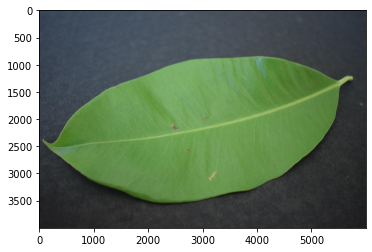

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

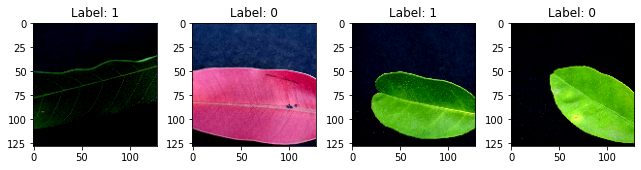

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:57:46] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:57:48] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2576075016817108 samples/sec                   batch loss = 0.7370942831039429 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.260257706124637 samples/sec                   batch loss = 0.5722096562385559 | accuracy = 0.675


Epoch[1] Batch[15] Speed: 1.266133217656871 samples/sec                   batch loss = 1.0913853645324707 | accuracy = 0.6666666666666666


Epoch[1] Batch[20] Speed: 1.2574754442424338 samples/sec                   batch loss = 0.7562845349311829 | accuracy = 0.6125


Epoch[1] Batch[25] Speed: 1.254214219901433 samples/sec                   batch loss = 0.585593044757843 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2612652950974723 samples/sec                   batch loss = 1.0389615297317505 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2651317674666924 samples/sec                   batch loss = 1.156784176826477 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.2640778005495206 samples/sec                   batch loss = 0.36086252331733704 | accuracy = 0.59375


Epoch[1] Batch[45] Speed: 1.2702517635806996 samples/sec                   batch loss = 0.5627148151397705 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.2699192793775849 samples/sec                   batch loss = 0.3700091540813446 | accuracy = 0.615


Epoch[1] Batch[55] Speed: 1.2709298667400566 samples/sec                   batch loss = 0.82247394323349 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.2672165546791578 samples/sec                   batch loss = 1.1041502952575684 | accuracy = 0.6208333333333333


Epoch[1] Batch[65] Speed: 1.2700153146265925 samples/sec                   batch loss = 0.36968961358070374 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.2658040317342498 samples/sec                   batch loss = 0.5592730641365051 | accuracy = 0.6035714285714285


Epoch[1] Batch[75] Speed: 1.267507692056636 samples/sec                   batch loss = 1.9731820821762085 | accuracy = 0.6033333333333334


Epoch[1] Batch[80] Speed: 1.2697152406778316 samples/sec                   batch loss = 0.40288716554641724 | accuracy = 0.596875


Epoch[1] Batch[85] Speed: 1.2674350148570601 samples/sec                   batch loss = 0.4853191673755646 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.2648640343328097 samples/sec                   batch loss = 0.4666372835636139 | accuracy = 0.6


Epoch[1] Batch[95] Speed: 1.2631102181041107 samples/sec                   batch loss = 0.6420708298683167 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.2660243935016062 samples/sec                   batch loss = 0.3906494081020355 | accuracy = 0.61


Epoch[1] Batch[105] Speed: 1.2609169334221584 samples/sec                   batch loss = 0.8466781377792358 | accuracy = 0.6047619047619047


Epoch[1] Batch[110] Speed: 1.261724858028639 samples/sec                   batch loss = 0.498426228761673 | accuracy = 0.6113636363636363


Epoch[1] Batch[115] Speed: 1.2673107456249184 samples/sec                   batch loss = 0.608076810836792 | accuracy = 0.6065217391304348


Epoch[1] Batch[120] Speed: 1.2674616334701054 samples/sec                   batch loss = 0.6540144085884094 | accuracy = 0.6104166666666667


Epoch[1] Batch[125] Speed: 1.264440680807037 samples/sec                   batch loss = 0.4103611409664154 | accuracy = 0.614


Epoch[1] Batch[130] Speed: 1.2633500008245517 samples/sec                   batch loss = 0.6157588958740234 | accuracy = 0.6211538461538462


Epoch[1] Batch[135] Speed: 1.2596023831006886 samples/sec                   batch loss = 0.5904203653335571 | accuracy = 0.6203703703703703


Epoch[1] Batch[140] Speed: 1.265270877002352 samples/sec                   batch loss = 0.29041826725006104 | accuracy = 0.625


Epoch[1] Batch[145] Speed: 1.2656195485122392 samples/sec                   batch loss = 0.3442179560661316 | accuracy = 0.6224137931034482


Epoch[1] Batch[150] Speed: 1.2563355880236824 samples/sec                   batch loss = 1.0741418600082397 | accuracy = 0.62


Epoch[1] Batch[155] Speed: 1.2678567353181178 samples/sec                   batch loss = 0.8146271705627441 | accuracy = 0.6209677419354839


Epoch[1] Batch[160] Speed: 1.2593800915116233 samples/sec                   batch loss = 0.6861642599105835 | accuracy = 0.6171875


Epoch[1] Batch[165] Speed: 1.2684735863075267 samples/sec                   batch loss = 1.328369140625 | accuracy = 0.6151515151515151


Epoch[1] Batch[170] Speed: 1.2668548537691373 samples/sec                   batch loss = 0.6244456171989441 | accuracy = 0.6147058823529412


Epoch[1] Batch[175] Speed: 1.2658649650256206 samples/sec                   batch loss = 0.4932016432285309 | accuracy = 0.6171428571428571


Epoch[1] Batch[180] Speed: 1.2621481037290778 samples/sec                   batch loss = 1.3724561929702759 | accuracy = 0.6166666666666667


Epoch[1] Batch[185] Speed: 1.26515676294765 samples/sec                   batch loss = 0.5821544528007507 | accuracy = 0.6175675675675676


Epoch[1] Batch[190] Speed: 1.2681034037068626 samples/sec                   batch loss = 0.3633609116077423 | accuracy = 0.625


Epoch[1] Batch[195] Speed: 1.2683324293012241 samples/sec                   batch loss = 0.7529813051223755 | accuracy = 0.6243589743589744


Epoch[1] Batch[200] Speed: 1.2682345392581456 samples/sec                   batch loss = 0.4062176048755646 | accuracy = 0.625


Epoch[1] Batch[205] Speed: 1.2696417336164443 samples/sec                   batch loss = 0.4602729380130768 | accuracy = 0.6304878048780488


Epoch[1] Batch[210] Speed: 1.2685799542902736 samples/sec                   batch loss = 0.9927768707275391 | accuracy = 0.625


Epoch[1] Batch[215] Speed: 1.2783556308032729 samples/sec                   batch loss = 0.5907801985740662 | accuracy = 0.6267441860465116


Epoch[1] Batch[220] Speed: 1.2717278311592881 samples/sec                   batch loss = 0.3158408999443054 | accuracy = 0.6295454545454545


Epoch[1] Batch[225] Speed: 1.276113011484489 samples/sec                   batch loss = 0.6742709279060364 | accuracy = 0.6277777777777778


Epoch[1] Batch[230] Speed: 1.2739930690262686 samples/sec                   batch loss = 1.0799719095230103 | accuracy = 0.6271739130434782


Epoch[1] Batch[235] Speed: 1.2685459990013268 samples/sec                   batch loss = 0.5839378833770752 | accuracy = 0.625531914893617


Epoch[1] Batch[240] Speed: 1.2690402565066692 samples/sec                   batch loss = 0.48191362619400024 | accuracy = 0.628125


Epoch[1] Batch[245] Speed: 1.273119122940959 samples/sec                   batch loss = 0.3948649764060974 | accuracy = 0.6306122448979592


Epoch[1] Batch[250] Speed: 1.2672694875015769 samples/sec                   batch loss = 0.5187360644340515 | accuracy = 0.631


Epoch[1] Batch[255] Speed: 1.2700288703209497 samples/sec                   batch loss = 0.5255560874938965 | accuracy = 0.6313725490196078


Epoch[1] Batch[260] Speed: 1.2756521237961982 samples/sec                   batch loss = 0.8773332834243774 | accuracy = 0.6307692307692307


Epoch[1] Batch[265] Speed: 1.2703955606618753 samples/sec                   batch loss = 0.6402303576469421 | accuracy = 0.629245283018868


Epoch[1] Batch[270] Speed: 1.2671595108738136 samples/sec                   batch loss = 0.5951563715934753 | accuracy = 0.6296296296296297


Epoch[1] Batch[275] Speed: 1.2697251383571633 samples/sec                   batch loss = 0.5963372588157654 | accuracy = 0.6318181818181818


Epoch[1] Batch[280] Speed: 1.2692048065605326 samples/sec                   batch loss = 0.6653068661689758 | accuracy = 0.6330357142857143


Epoch[1] Batch[285] Speed: 1.269674978893259 samples/sec                   batch loss = 0.5351040363311768 | accuracy = 0.6350877192982456


Epoch[1] Batch[290] Speed: 1.2671828637571259 samples/sec                   batch loss = 0.7149763107299805 | accuracy = 0.6327586206896552


Epoch[1] Batch[295] Speed: 1.2683526611551454 samples/sec                   batch loss = 0.434297114610672 | accuracy = 0.6364406779661017


Epoch[1] Batch[300] Speed: 1.269532785865561 samples/sec                   batch loss = 0.7579504251480103 | accuracy = 0.6358333333333334


Epoch[1] Batch[305] Speed: 1.2660364310743837 samples/sec                   batch loss = 0.6563236713409424 | accuracy = 0.6360655737704918


Epoch[1] Batch[310] Speed: 1.268349017456074 samples/sec                   batch loss = 0.4411618709564209 | accuracy = 0.6370967741935484


Epoch[1] Batch[315] Speed: 1.2701846373611632 samples/sec                   batch loss = 0.39543747901916504 | accuracy = 0.6388888888888888


Epoch[1] Batch[320] Speed: 1.2643307181911916 samples/sec                   batch loss = 0.2804180681705475 | accuracy = 0.640625


Epoch[1] Batch[325] Speed: 1.2707060617586854 samples/sec                   batch loss = 0.7901491522789001 | accuracy = 0.6423076923076924


Epoch[1] Batch[330] Speed: 1.275362856471948 samples/sec                   batch loss = 0.6080124378204346 | accuracy = 0.6439393939393939


Epoch[1] Batch[335] Speed: 1.270188772438962 samples/sec                   batch loss = 0.5336581468582153 | accuracy = 0.6447761194029851


Epoch[1] Batch[340] Speed: 1.2725322998474375 samples/sec                   batch loss = 0.3825605511665344 | accuracy = 0.6470588235294118


Epoch[1] Batch[345] Speed: 1.2719080247288426 samples/sec                   batch loss = 0.48391175270080566 | accuracy = 0.65


Epoch[1] Batch[350] Speed: 1.2719055176729819 samples/sec                   batch loss = 1.3513143062591553 | accuracy = 0.6492857142857142


Epoch[1] Batch[355] Speed: 1.2700959800772298 samples/sec                   batch loss = 0.628212034702301 | accuracy = 0.6485915492957747


Epoch[1] Batch[360] Speed: 1.2587217142943314 samples/sec                   batch loss = 0.5872278213500977 | accuracy = 0.6486111111111111


Epoch[1] Batch[365] Speed: 1.2599046969501493 samples/sec                   batch loss = 0.35585901141166687 | accuracy = 0.6513698630136986


Epoch[1] Batch[370] Speed: 1.2641421873032692 samples/sec                   batch loss = 0.37992554903030396 | accuracy = 0.652027027027027


Epoch[1] Batch[375] Speed: 1.264175049934912 samples/sec                   batch loss = 0.5895565152168274 | accuracy = 0.654


Epoch[1] Batch[380] Speed: 1.257618248475241 samples/sec                   batch loss = 0.6989583969116211 | accuracy = 0.6519736842105263


Epoch[1] Batch[385] Speed: 1.260459284503793 samples/sec                   batch loss = 0.47854775190353394 | accuracy = 0.6538961038961039


Epoch[1] Batch[390] Speed: 1.2572252615619848 samples/sec                   batch loss = 0.5947198867797852 | accuracy = 0.6557692307692308


Epoch[1] Batch[395] Speed: 1.2665901201202991 samples/sec                   batch loss = 0.6642002463340759 | accuracy = 0.6556962025316456


Epoch[1] Batch[400] Speed: 1.2621329117099855 samples/sec                   batch loss = 1.0243027210235596 | accuracy = 0.656875


Epoch[1] Batch[405] Speed: 1.2619618368457874 samples/sec                   batch loss = 0.5133367776870728 | accuracy = 0.6574074074074074


Epoch[1] Batch[410] Speed: 1.2606754208728403 samples/sec                   batch loss = 0.28728988766670227 | accuracy = 0.6579268292682927


Epoch[1] Batch[415] Speed: 1.2596130694454026 samples/sec                   batch loss = 0.3470393419265747 | accuracy = 0.6590361445783133


Epoch[1] Batch[420] Speed: 1.2595100908904593 samples/sec                   batch loss = 0.23122428357601166 | accuracy = 0.6607142857142857


Epoch[1] Batch[425] Speed: 1.2584607461240216 samples/sec                   batch loss = 0.26868271827697754 | accuracy = 0.6611764705882353


Epoch[1] Batch[430] Speed: 1.2636182353949545 samples/sec                   batch loss = 0.8112121820449829 | accuracy = 0.6627906976744186


Epoch[1] Batch[435] Speed: 1.2571437734493784 samples/sec                   batch loss = 0.39295822381973267 | accuracy = 0.6620689655172414


Epoch[1] Batch[440] Speed: 1.2659825503866189 samples/sec                   batch loss = 0.2938266098499298 | accuracy = 0.6625


Epoch[1] Batch[445] Speed: 1.2613683712099852 samples/sec                   batch loss = 0.565049409866333 | accuracy = 0.6623595505617977


Epoch[1] Batch[450] Speed: 1.2655216949278858 samples/sec                   batch loss = 0.315959095954895 | accuracy = 0.6622222222222223


Epoch[1] Batch[455] Speed: 1.2614910034675706 samples/sec                   batch loss = 0.692105233669281 | accuracy = 0.6620879120879121


Epoch[1] Batch[460] Speed: 1.2632783703504695 samples/sec                   batch loss = 0.7617394924163818 | accuracy = 0.6625


Epoch[1] Batch[465] Speed: 1.2550045626761497 samples/sec                   batch loss = 0.3696557581424713 | accuracy = 0.6634408602150538


Epoch[1] Batch[470] Speed: 1.2654226156929995 samples/sec                   batch loss = 0.5677459239959717 | accuracy = 0.6632978723404256


Epoch[1] Batch[475] Speed: 1.2590614938219202 samples/sec                   batch loss = 0.31546106934547424 | accuracy = 0.6642105263157895


Epoch[1] Batch[480] Speed: 1.2609065092361322 samples/sec                   batch loss = 1.0519628524780273 | accuracy = 0.6645833333333333


Epoch[1] Batch[485] Speed: 1.2597067009271643 samples/sec                   batch loss = 0.5971006751060486 | accuracy = 0.6670103092783505


Epoch[1] Batch[490] Speed: 1.260534668088898 samples/sec                   batch loss = 0.3890458047389984 | accuracy = 0.6673469387755102


Epoch[1] Batch[495] Speed: 1.2666483558546757 samples/sec                   batch loss = 0.6229397058486938 | accuracy = 0.6681818181818182


Epoch[1] Batch[500] Speed: 1.2607767899219113 samples/sec                   batch loss = 0.7298222780227661 | accuracy = 0.668


Epoch[1] Batch[505] Speed: 1.2621344308954374 samples/sec                   batch loss = 0.36728328466415405 | accuracy = 0.6707920792079208


Epoch[1] Batch[510] Speed: 1.256279425534934 samples/sec                   batch loss = 1.2210813760757446 | accuracy = 0.6715686274509803


Epoch[1] Batch[515] Speed: 1.2635281133833371 samples/sec                   batch loss = 0.28588375449180603 | accuracy = 0.6723300970873787


Epoch[1] Batch[520] Speed: 1.2644030398037274 samples/sec                   batch loss = 1.0660468339920044 | accuracy = 0.6725961538461539


Epoch[1] Batch[525] Speed: 1.269564584379025 samples/sec                   batch loss = 0.8060711622238159 | accuracy = 0.6733333333333333


Epoch[1] Batch[530] Speed: 1.2651268066490053 samples/sec                   batch loss = 0.6667840480804443 | accuracy = 0.6745283018867925


Epoch[1] Batch[535] Speed: 1.264276410957112 samples/sec                   batch loss = 0.5282948017120361 | accuracy = 0.6761682242990654


Epoch[1] Batch[540] Speed: 1.2653816712914563 samples/sec                   batch loss = 0.29864490032196045 | accuracy = 0.6773148148148148


Epoch[1] Batch[545] Speed: 1.2685351605488755 samples/sec                   batch loss = 0.35544559359550476 | accuracy = 0.676605504587156


Epoch[1] Batch[550] Speed: 1.2646131910339573 samples/sec                   batch loss = 0.6792502999305725 | accuracy = 0.6772727272727272


Epoch[1] Batch[555] Speed: 1.26212550573328 samples/sec                   batch loss = 0.4517734944820404 | accuracy = 0.6779279279279279


Epoch[1] Batch[560] Speed: 1.2635157428329336 samples/sec                   batch loss = 0.22419710457324982 | accuracy = 0.6803571428571429


Epoch[1] Batch[565] Speed: 1.2673891530350623 samples/sec                   batch loss = 0.21244271099567413 | accuracy = 0.6805309734513274


Epoch[1] Batch[570] Speed: 1.2634506586961178 samples/sec                   batch loss = 0.6502562761306763 | accuracy = 0.6820175438596491


Epoch[1] Batch[575] Speed: 1.2671690816235357 samples/sec                   batch loss = 0.3425973653793335 | accuracy = 0.6817391304347826


Epoch[1] Batch[580] Speed: 1.2725874152077585 samples/sec                   batch loss = 0.932462215423584 | accuracy = 0.680603448275862


Epoch[1] Batch[585] Speed: 1.2623787824977277 samples/sec                   batch loss = 0.7956149578094482 | accuracy = 0.6807692307692308


Epoch[1] Batch[590] Speed: 1.2610934126175066 samples/sec                   batch loss = 0.5647664070129395 | accuracy = 0.6826271186440678


Epoch[1] Batch[595] Speed: 1.259523139582826 samples/sec                   batch loss = 0.5121625661849976 | accuracy = 0.6819327731092437


Epoch[1] Batch[600] Speed: 1.2633147077697109 samples/sec                   batch loss = 0.5023148655891418 | accuracy = 0.68375


Epoch[1] Batch[605] Speed: 1.2623206537588636 samples/sec                   batch loss = 0.6481707692146301 | accuracy = 0.6834710743801653


Epoch[1] Batch[610] Speed: 1.2594222556422359 samples/sec                   batch loss = 0.24680094420909882 | accuracy = 0.6844262295081968


Epoch[1] Batch[615] Speed: 1.2641640002796994 samples/sec                   batch loss = 0.45967763662338257 | accuracy = 0.6833333333333333


Epoch[1] Batch[620] Speed: 1.266889675242597 samples/sec                   batch loss = 1.1322705745697021 | accuracy = 0.6830645161290323


Epoch[1] Batch[625] Speed: 1.2677745338455246 samples/sec                   batch loss = 0.4352022707462311 | accuracy = 0.6832


Epoch[1] Batch[630] Speed: 1.2644377266219387 samples/sec                   batch loss = 0.5916226506233215 | accuracy = 0.6837301587301587


Epoch[1] Batch[635] Speed: 1.2609807142408864 samples/sec                   batch loss = 0.4043590724468231 | accuracy = 0.6838582677165355


Epoch[1] Batch[640] Speed: 1.267141326847635 samples/sec                   batch loss = 0.6114910840988159 | accuracy = 0.68359375


Epoch[1] Batch[645] Speed: 1.263827935397883 samples/sec                   batch loss = 0.38666006922721863 | accuracy = 0.6844961240310078


Epoch[1] Batch[650] Speed: 1.2638248888715462 samples/sec                   batch loss = 0.3752695918083191 | accuracy = 0.6846153846153846


Epoch[1] Batch[655] Speed: 1.2632200636247526 samples/sec                   batch loss = 0.4061186611652374 | accuracy = 0.684351145038168


Epoch[1] Batch[660] Speed: 1.268537750250763 samples/sec                   batch loss = 0.37079304456710815 | accuracy = 0.6852272727272727


Epoch[1] Batch[665] Speed: 1.2656279503058265 samples/sec                   batch loss = 0.5744184255599976 | accuracy = 0.6857142857142857


Epoch[1] Batch[670] Speed: 1.2667008586682198 samples/sec                   batch loss = 0.681876003742218 | accuracy = 0.6854477611940298


Epoch[1] Batch[675] Speed: 1.2671055345523683 samples/sec                   batch loss = 0.6749266386032104 | accuracy = 0.6866666666666666


Epoch[1] Batch[680] Speed: 1.2667478184236234 samples/sec                   batch loss = 0.8969813585281372 | accuracy = 0.6856617647058824


Epoch[1] Batch[685] Speed: 1.266850740369846 samples/sec                   batch loss = 1.4825491905212402 | accuracy = 0.6857664233576642


Epoch[1] Batch[690] Speed: 1.2686362626881842 samples/sec                   batch loss = 0.27994057536125183 | accuracy = 0.6865942028985508


Epoch[1] Batch[695] Speed: 1.2717148175495143 samples/sec                   batch loss = 0.5400463342666626 | accuracy = 0.6859712230215828


Epoch[1] Batch[700] Speed: 1.26779426889104 samples/sec                   batch loss = 0.4843975603580475 | accuracy = 0.685


Epoch[1] Batch[705] Speed: 1.2651637275133183 samples/sec                   batch loss = 0.4680018424987793 | accuracy = 0.6858156028368795


Epoch[1] Batch[710] Speed: 1.2668281649795725 samples/sec                   batch loss = 0.46508416533470154 | accuracy = 0.6859154929577465


Epoch[1] Batch[715] Speed: 1.270839372652619 samples/sec                   batch loss = 0.4009760618209839 | accuracy = 0.6867132867132867


Epoch[1] Batch[720] Speed: 1.2673958549731634 samples/sec                   batch loss = 0.588821530342102 | accuracy = 0.6868055555555556


Epoch[1] Batch[725] Speed: 1.2680102449253035 samples/sec                   batch loss = 0.27125284075737 | accuracy = 0.6879310344827586


Epoch[1] Batch[730] Speed: 1.2727828187987078 samples/sec                   batch loss = 0.680275022983551 | accuracy = 0.6876712328767123


Epoch[1] Batch[735] Speed: 1.2628861164181286 samples/sec                   batch loss = 0.5165097713470459 | accuracy = 0.6880952380952381


Epoch[1] Batch[740] Speed: 1.2620569571000189 samples/sec                   batch loss = 0.4964762032032013 | accuracy = 0.6868243243243243


Epoch[1] Batch[745] Speed: 1.2687506215300661 samples/sec                   batch loss = 0.3554575443267822 | accuracy = 0.6879194630872483


Epoch[1] Batch[750] Speed: 1.2636419338134914 samples/sec                   batch loss = 0.29049408435821533 | accuracy = 0.6883333333333334


Epoch[1] Batch[755] Speed: 1.262029710611745 samples/sec                   batch loss = 0.4995229244232178 | accuracy = 0.6890728476821192


Epoch[1] Batch[760] Speed: 1.2640566572178198 samples/sec                   batch loss = 0.5323905944824219 | accuracy = 0.6894736842105263


Epoch[1] Batch[765] Speed: 1.2673750791957585 samples/sec                   batch loss = 0.40596556663513184 | accuracy = 0.6888888888888889


Epoch[1] Batch[770] Speed: 1.262939638781481 samples/sec                   batch loss = 0.1411207616329193 | accuracy = 0.689935064935065


Epoch[1] Batch[775] Speed: 1.269023554277648 samples/sec                   batch loss = 0.37115365266799927 | accuracy = 0.6896774193548387


Epoch[1] Batch[780] Speed: 1.2711420970369671 samples/sec                   batch loss = 0.34974604845046997 | accuracy = 0.6903846153846154


Epoch[1] Batch[785] Speed: 1.2705818238631386 samples/sec                   batch loss = 0.5065476298332214 | accuracy = 0.6901273885350319


[Epoch 1] training: accuracy=0.6900380710659898
[Epoch 1] time cost: 650.9462387561798
[Epoch 1] validation: validation accuracy=0.7133333333333334


Epoch[2] Batch[5] Speed: 1.2651321490696643 samples/sec                   batch loss = 0.6033660173416138 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2619956304236548 samples/sec                   batch loss = 0.3298422694206238 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2644030398037274 samples/sec                   batch loss = 0.6349529027938843 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2659763410276166 samples/sec                   batch loss = 0.7321552634239197 | accuracy = 0.7125


Epoch[2] Batch[25] Speed: 1.2596718002931213 samples/sec                   batch loss = 0.7696122527122498 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.255587919209941 samples/sec                   batch loss = 0.4643756151199341 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2608365768814083 samples/sec                   batch loss = 0.3239680528640747 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2645563813636471 samples/sec                   batch loss = 0.5644128918647766 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2674271635372465 samples/sec                   batch loss = 0.31259357929229736 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.265697173873486 samples/sec                   batch loss = 0.16429312527179718 | accuracy = 0.78


Epoch[2] Batch[55] Speed: 1.2623480077926432 samples/sec                   batch loss = 0.6364136338233948 | accuracy = 0.7681818181818182


Epoch[2] Batch[60] Speed: 1.2692938196165824 samples/sec                   batch loss = 0.4500262141227722 | accuracy = 0.775


Epoch[2] Batch[65] Speed: 1.2682703953653731 samples/sec                   batch loss = 0.7580868005752563 | accuracy = 0.7730769230769231


Epoch[2] Batch[70] Speed: 1.2649697024166364 samples/sec                   batch loss = 0.4752511978149414 | accuracy = 0.7714285714285715


Epoch[2] Batch[75] Speed: 1.2633822514587032 samples/sec                   batch loss = 0.12219233810901642 | accuracy = 0.78


Epoch[2] Batch[80] Speed: 1.2670808447892397 samples/sec                   batch loss = 0.4447365999221802 | accuracy = 0.778125


Epoch[2] Batch[85] Speed: 1.2657299264208233 samples/sec                   batch loss = 0.6294522881507874 | accuracy = 0.7823529411764706


Epoch[2] Batch[90] Speed: 1.2721038949064787 samples/sec                   batch loss = 0.37286999821662903 | accuracy = 0.7833333333333333


Epoch[2] Batch[95] Speed: 1.2709586542632436 samples/sec                   batch loss = 0.46420684456825256 | accuracy = 0.781578947368421


Epoch[2] Batch[100] Speed: 1.2699877234334358 samples/sec                   batch loss = 0.2725498378276825 | accuracy = 0.7875


Epoch[2] Batch[105] Speed: 1.2753492836220335 samples/sec                   batch loss = 0.7417389154434204 | accuracy = 0.7880952380952381


Epoch[2] Batch[110] Speed: 1.2713052659639885 samples/sec                   batch loss = 0.26661232113838196 | accuracy = 0.7931818181818182


Epoch[2] Batch[115] Speed: 1.275527110855389 samples/sec                   batch loss = 0.460021048784256 | accuracy = 0.7978260869565217


Epoch[2] Batch[120] Speed: 1.2700277166335683 samples/sec                   batch loss = 0.7206063270568848 | accuracy = 0.7895833333333333


Epoch[2] Batch[125] Speed: 1.2769107939699715 samples/sec                   batch loss = 0.3184110224246979 | accuracy = 0.788


Epoch[2] Batch[130] Speed: 1.272877452772621 samples/sec                   batch loss = 0.6500550508499146 | accuracy = 0.7884615384615384


Epoch[2] Batch[135] Speed: 1.2758749578028252 samples/sec                   batch loss = 0.24145695567131042 | accuracy = 0.7907407407407407


Epoch[2] Batch[140] Speed: 1.2683200603814482 samples/sec                   batch loss = 0.2993682324886322 | accuracy = 0.7892857142857143


Epoch[2] Batch[145] Speed: 1.273282220049812 samples/sec                   batch loss = 0.4690884053707123 | accuracy = 0.7913793103448276


Epoch[2] Batch[150] Speed: 1.2678948696904704 samples/sec                   batch loss = 0.3626691997051239 | accuracy = 0.7883333333333333


Epoch[2] Batch[155] Speed: 1.270153961694491 samples/sec                   batch loss = 0.5482946038246155 | accuracy = 0.7887096774193548


Epoch[2] Batch[160] Speed: 1.2697720343140557 samples/sec                   batch loss = 0.30192431807518005 | accuracy = 0.790625


Epoch[2] Batch[165] Speed: 1.275037478490622 samples/sec                   batch loss = 0.5501043796539307 | accuracy = 0.7878787878787878


Epoch[2] Batch[170] Speed: 1.2710111298595739 samples/sec                   batch loss = 0.18669144809246063 | accuracy = 0.7867647058823529


Epoch[2] Batch[175] Speed: 1.2755723997574338 samples/sec                   batch loss = 0.06759937107563019 | accuracy = 0.7885714285714286


Epoch[2] Batch[180] Speed: 1.2686518035350445 samples/sec                   batch loss = 0.2734430134296417 | accuracy = 0.7819444444444444


Epoch[2] Batch[185] Speed: 1.266346716390974 samples/sec                   batch loss = 0.24166366457939148 | accuracy = 0.7824324324324324


Epoch[2] Batch[190] Speed: 1.2666683427514955 samples/sec                   batch loss = 0.30584779381752014 | accuracy = 0.7828947368421053


Epoch[2] Batch[195] Speed: 1.268163216559306 samples/sec                   batch loss = 0.7237519025802612 | accuracy = 0.782051282051282


Epoch[2] Batch[200] Speed: 1.265347886997298 samples/sec                   batch loss = 0.23296372592449188 | accuracy = 0.78125


Epoch[2] Batch[205] Speed: 1.263155200150339 samples/sec                   batch loss = 0.9725209474563599 | accuracy = 0.7792682926829269


Epoch[2] Batch[210] Speed: 1.256974707540058 samples/sec                   batch loss = 0.2806628942489624 | accuracy = 0.7785714285714286


Epoch[2] Batch[215] Speed: 1.2556519138509787 samples/sec                   batch loss = 0.31872236728668213 | accuracy = 0.7802325581395348


Epoch[2] Batch[220] Speed: 1.2537547704579213 samples/sec                   batch loss = 0.4523713290691376 | accuracy = 0.7818181818181819


Epoch[2] Batch[225] Speed: 1.2626414733662994 samples/sec                   batch loss = 1.1094610691070557 | accuracy = 0.7811111111111111


Epoch[2] Batch[230] Speed: 1.2547535791278464 samples/sec                   batch loss = 0.1595294326543808 | accuracy = 0.782608695652174


Epoch[2] Batch[235] Speed: 1.2544507304499957 samples/sec                   batch loss = 0.7640789151191711 | accuracy = 0.7808510638297872


Epoch[2] Batch[240] Speed: 1.2577109236226136 samples/sec                   batch loss = 0.21093906462192535 | accuracy = 0.7822916666666667


Epoch[2] Batch[245] Speed: 1.2592188350352995 samples/sec                   batch loss = 0.9461352825164795 | accuracy = 0.7816326530612245


Epoch[2] Batch[250] Speed: 1.2581146865094828 samples/sec                   batch loss = 0.3156610429286957 | accuracy = 0.781


Epoch[2] Batch[255] Speed: 1.2538529679955104 samples/sec                   batch loss = 0.09654418379068375 | accuracy = 0.7803921568627451


Epoch[2] Batch[260] Speed: 1.2578058756028987 samples/sec                   batch loss = 0.6229040026664734 | accuracy = 0.7798076923076923


Epoch[2] Batch[265] Speed: 1.2580260081174888 samples/sec                   batch loss = 0.3337015211582184 | accuracy = 0.7830188679245284


Epoch[2] Batch[270] Speed: 1.2603138461838943 samples/sec                   batch loss = 0.23001918196678162 | accuracy = 0.7851851851851852


Epoch[2] Batch[275] Speed: 1.2581111957406694 samples/sec                   batch loss = 0.3222835958003998 | accuracy = 0.7836363636363637


Epoch[2] Batch[280] Speed: 1.2603811640462215 samples/sec                   batch loss = 0.32353493571281433 | accuracy = 0.7839285714285714


Epoch[2] Batch[285] Speed: 1.2654951577349218 samples/sec                   batch loss = 0.30397605895996094 | accuracy = 0.7868421052631579


Epoch[2] Batch[290] Speed: 1.265787128083152 samples/sec                   batch loss = 0.6747093796730042 | accuracy = 0.7870689655172414


Epoch[2] Batch[295] Speed: 1.2590800136285383 samples/sec                   batch loss = 0.22431319952011108 | accuracy = 0.7864406779661017


Epoch[2] Batch[300] Speed: 1.2633108075800685 samples/sec                   batch loss = 0.9088623523712158 | accuracy = 0.785


Epoch[2] Batch[305] Speed: 1.2671605636492063 samples/sec                   batch loss = 0.43283355236053467 | accuracy = 0.7836065573770492


Epoch[2] Batch[310] Speed: 1.2646938390294706 samples/sec                   batch loss = 0.18407480418682098 | accuracy = 0.7806451612903226


Epoch[2] Batch[315] Speed: 1.2646090921788435 samples/sec                   batch loss = 1.1274431943893433 | accuracy = 0.776984126984127


Epoch[2] Batch[320] Speed: 1.2595528310932647 samples/sec                   batch loss = 1.7891366481781006 | accuracy = 0.77265625


Epoch[2] Batch[325] Speed: 1.2595369450154676 samples/sec                   batch loss = 0.3169349730014801 | accuracy = 0.7730769230769231


Epoch[2] Batch[330] Speed: 1.2627604565147312 samples/sec                   batch loss = 0.48761019110679626 | accuracy = 0.7696969696969697


Epoch[2] Batch[335] Speed: 1.2610191943486142 samples/sec                   batch loss = 0.32149192690849304 | accuracy = 0.7701492537313432


Epoch[2] Batch[340] Speed: 1.2651084901207135 samples/sec                   batch loss = 0.52122563123703 | accuracy = 0.7691176470588236


Epoch[2] Batch[345] Speed: 1.2659549430878445 samples/sec                   batch loss = 0.9188321828842163 | accuracy = 0.768840579710145


Epoch[2] Batch[350] Speed: 1.2608884094680326 samples/sec                   batch loss = 0.29706159234046936 | accuracy = 0.7692857142857142


Epoch[2] Batch[355] Speed: 1.262477100636799 samples/sec                   batch loss = 0.5651582479476929 | accuracy = 0.7697183098591549


Epoch[2] Batch[360] Speed: 1.263682575339428 samples/sec                   batch loss = 0.36886700987815857 | accuracy = 0.7701388888888889


Epoch[2] Batch[365] Speed: 1.2644398231389735 samples/sec                   batch loss = 0.3756827712059021 | accuracy = 0.7698630136986301


Epoch[2] Batch[370] Speed: 1.2663155567622018 samples/sec                   batch loss = 1.346300482749939 | accuracy = 0.7668918918918919


Epoch[2] Batch[375] Speed: 1.265644658749568 samples/sec                   batch loss = 0.5446650385856628 | accuracy = 0.7673333333333333


Epoch[2] Batch[380] Speed: 1.2676090135760938 samples/sec                   batch loss = 0.48210835456848145 | accuracy = 0.7684210526315789


Epoch[2] Batch[385] Speed: 1.2662779951991194 samples/sec                   batch loss = 0.532664954662323 | accuracy = 0.7688311688311689


Epoch[2] Batch[390] Speed: 1.2660584050118273 samples/sec                   batch loss = 0.3728626072406769 | accuracy = 0.7685897435897436


Epoch[2] Batch[395] Speed: 1.2695134769715701 samples/sec                   batch loss = 1.12253737449646 | accuracy = 0.7683544303797468


Epoch[2] Batch[400] Speed: 1.267148121870029 samples/sec                   batch loss = 0.8299470543861389 | accuracy = 0.768125


Epoch[2] Batch[405] Speed: 1.2677626547939658 samples/sec                   batch loss = 0.3783814311027527 | accuracy = 0.769753086419753


Epoch[2] Batch[410] Speed: 1.2641207560726668 samples/sec                   batch loss = 0.12786906957626343 | accuracy = 0.7701219512195122


Epoch[2] Batch[415] Speed: 1.2624899258709654 samples/sec                   batch loss = 0.2766337990760803 | accuracy = 0.7698795180722892


Epoch[2] Batch[420] Speed: 1.2668288345770276 samples/sec                   batch loss = 0.24492762982845306 | accuracy = 0.7702380952380953


Epoch[2] Batch[425] Speed: 1.2649753296418274 samples/sec                   batch loss = 0.36282894015312195 | accuracy = 0.77


Epoch[2] Batch[430] Speed: 1.2701331915514404 samples/sec                   batch loss = 0.9028052091598511 | accuracy = 0.7697674418604651


Epoch[2] Batch[435] Speed: 1.266174115151759 samples/sec                   batch loss = 0.5930346846580505 | accuracy = 0.767816091954023


Epoch[2] Batch[440] Speed: 1.2702382031278332 samples/sec                   batch loss = 0.4745410084724426 | accuracy = 0.7693181818181818


Epoch[2] Batch[445] Speed: 1.2678145793852391 samples/sec                   batch loss = 1.2670981884002686 | accuracy = 0.7691011235955056


Epoch[2] Batch[450] Speed: 1.2641250422606547 samples/sec                   batch loss = 0.26945003867149353 | accuracy = 0.77


Epoch[2] Batch[455] Speed: 1.2679644372938932 samples/sec                   batch loss = 0.3358456492424011 | accuracy = 0.771978021978022


Epoch[2] Batch[460] Speed: 1.2709738669258934 samples/sec                   batch loss = 0.3399868309497833 | accuracy = 0.7739130434782608


Epoch[2] Batch[465] Speed: 1.2766300869462393 samples/sec                   batch loss = 1.111690878868103 | accuracy = 0.7741935483870968


Epoch[2] Batch[470] Speed: 1.2747127507471376 samples/sec                   batch loss = 0.8448947668075562 | accuracy = 0.774468085106383


Epoch[2] Batch[475] Speed: 1.273718961708828 samples/sec                   batch loss = 0.5769140124320984 | accuracy = 0.7731578947368422


Epoch[2] Batch[480] Speed: 1.274180582260448 samples/sec                   batch loss = 0.4835605025291443 | accuracy = 0.7739583333333333


Epoch[2] Batch[485] Speed: 1.2709907168190808 samples/sec                   batch loss = 0.27106592059135437 | accuracy = 0.7731958762886598


Epoch[2] Batch[490] Speed: 1.2712410144034747 samples/sec                   batch loss = 1.963766098022461 | accuracy = 0.7729591836734694


Epoch[2] Batch[495] Speed: 1.2717553052101425 samples/sec                   batch loss = 0.44722554087638855 | accuracy = 0.7732323232323233


Epoch[2] Batch[500] Speed: 1.2726826959255257 samples/sec                   batch loss = 0.5642631649971008 | accuracy = 0.7705


Epoch[2] Batch[505] Speed: 1.2653371031250416 samples/sec                   batch loss = 0.33390021324157715 | accuracy = 0.7698019801980198


Epoch[2] Batch[510] Speed: 1.2600552458427987 samples/sec                   batch loss = 0.26259171962738037 | accuracy = 0.7705882352941177


Epoch[2] Batch[515] Speed: 1.2615688821126168 samples/sec                   batch loss = 0.39639556407928467 | accuracy = 0.7708737864077669


Epoch[2] Batch[520] Speed: 1.2582321574560114 samples/sec                   batch loss = 0.07229764014482498 | accuracy = 0.7711538461538462


Epoch[2] Batch[525] Speed: 1.2598263614126994 samples/sec                   batch loss = 0.2482801079750061 | accuracy = 0.7704761904761904


Epoch[2] Batch[530] Speed: 1.2532033510451754 samples/sec                   batch loss = 0.24168482422828674 | accuracy = 0.7702830188679245


Epoch[2] Batch[535] Speed: 1.2601013355685442 samples/sec                   batch loss = 0.7304067611694336 | accuracy = 0.7705607476635514


Epoch[2] Batch[540] Speed: 1.257090364429379 samples/sec                   batch loss = 0.47915124893188477 | accuracy = 0.7703703703703704


Epoch[2] Batch[545] Speed: 1.25609761393191 samples/sec                   batch loss = 0.28994518518447876 | accuracy = 0.771559633027523


Epoch[2] Batch[550] Speed: 1.2564129254970282 samples/sec                   batch loss = 0.5199499726295471 | accuracy = 0.7709090909090909


Epoch[2] Batch[555] Speed: 1.256710415386246 samples/sec                   batch loss = 0.20533055067062378 | accuracy = 0.7711711711711712


Epoch[2] Batch[560] Speed: 1.2631790714168476 samples/sec                   batch loss = 0.3388446867465973 | accuracy = 0.7705357142857143


Epoch[2] Batch[565] Speed: 1.2581094975358185 samples/sec                   batch loss = 0.39825204014778137 | accuracy = 0.7703539823008849


Epoch[2] Batch[570] Speed: 1.261033601298584 samples/sec                   batch loss = 0.7318364381790161 | accuracy = 0.769298245614035


Epoch[2] Batch[575] Speed: 1.2572315737988131 samples/sec                   batch loss = 0.5317237377166748 | accuracy = 0.7695652173913043


Epoch[2] Batch[580] Speed: 1.2634557015255559 samples/sec                   batch loss = 0.20310549437999725 | accuracy = 0.7706896551724138


Epoch[2] Batch[585] Speed: 1.2594720810231672 samples/sec                   batch loss = 0.42139187455177307 | accuracy = 0.7705128205128206


Epoch[2] Batch[590] Speed: 1.2517890010968775 samples/sec                   batch loss = 0.4336144030094147 | accuracy = 0.7711864406779662


Epoch[2] Batch[595] Speed: 1.2500680647598004 samples/sec                   batch loss = 0.34859752655029297 | accuracy = 0.7718487394957984


Epoch[2] Batch[600] Speed: 1.2613828809758438 samples/sec                   batch loss = 0.3993619680404663 | accuracy = 0.77125


Epoch[2] Batch[605] Speed: 1.2587944345450703 samples/sec                   batch loss = 0.20409069955348969 | accuracy = 0.7710743801652893


Epoch[2] Batch[610] Speed: 1.2579221570871646 samples/sec                   batch loss = 0.32093390822410583 | accuracy = 0.771311475409836


Epoch[2] Batch[615] Speed: 1.2569316712810505 samples/sec                   batch loss = 0.4149726331233978 | accuracy = 0.7707317073170732


Epoch[2] Batch[620] Speed: 1.2549630693142553 samples/sec                   batch loss = 0.7513430118560791 | accuracy = 0.7713709677419355


Epoch[2] Batch[625] Speed: 1.2507661841372206 samples/sec                   batch loss = 0.7856283783912659 | accuracy = 0.7708


Epoch[2] Batch[630] Speed: 1.2589224237032448 samples/sec                   batch loss = 0.3991210162639618 | accuracy = 0.7706349206349207


Epoch[2] Batch[635] Speed: 1.2573209882594096 samples/sec                   batch loss = 0.5791189074516296 | accuracy = 0.771259842519685


Epoch[2] Batch[640] Speed: 1.256920371220138 samples/sec                   batch loss = 0.29618415236473083 | accuracy = 0.7703125


Epoch[2] Batch[645] Speed: 1.256194203611057 samples/sec                   batch loss = 0.7643741369247437 | accuracy = 0.7693798449612403


Epoch[2] Batch[650] Speed: 1.2585031319274165 samples/sec                   batch loss = 0.2665252387523651 | accuracy = 0.7696153846153846


Epoch[2] Batch[655] Speed: 1.2572855601447182 samples/sec                   batch loss = 0.35070323944091797 | accuracy = 0.7706106870229008


Epoch[2] Batch[660] Speed: 1.2633259328401478 samples/sec                   batch loss = 0.7297743558883667 | accuracy = 0.7700757575757575


Epoch[2] Batch[665] Speed: 1.259577701174537 samples/sec                   batch loss = 0.1530626267194748 | accuracy = 0.7710526315789473


Epoch[2] Batch[670] Speed: 1.254333401817246 samples/sec                   batch loss = 0.43098342418670654 | accuracy = 0.7708955223880597


Epoch[2] Batch[675] Speed: 1.2558115999958084 samples/sec                   batch loss = 0.1983802616596222 | accuracy = 0.7714814814814814


Epoch[2] Batch[680] Speed: 1.2550573251666761 samples/sec                   batch loss = 0.5181980133056641 | accuracy = 0.7716911764705883


Epoch[2] Batch[685] Speed: 1.2528658835428472 samples/sec                   batch loss = 0.585090696811676 | accuracy = 0.7718978102189781


Epoch[2] Batch[690] Speed: 1.2584685811465126 samples/sec                   batch loss = 0.7305615544319153 | accuracy = 0.7728260869565218


Epoch[2] Batch[695] Speed: 1.257838315314571 samples/sec                   batch loss = 2.995215654373169 | accuracy = 0.7726618705035971


Epoch[2] Batch[700] Speed: 1.2567575787266798 samples/sec                   batch loss = 0.4339292347431183 | accuracy = 0.7725


Epoch[2] Batch[705] Speed: 1.2591920889800607 samples/sec                   batch loss = 0.6017876267433167 | accuracy = 0.7723404255319148


Epoch[2] Batch[710] Speed: 1.2540635636175108 samples/sec                   batch loss = 0.7093415260314941 | accuracy = 0.7718309859154929


Epoch[2] Batch[715] Speed: 1.2527567087741422 samples/sec                   batch loss = 0.18913936614990234 | accuracy = 0.7716783216783217


Epoch[2] Batch[720] Speed: 1.2560631951045236 samples/sec                   batch loss = 0.9372319579124451 | accuracy = 0.7708333333333334


Epoch[2] Batch[725] Speed: 1.2611041242768024 samples/sec                   batch loss = 0.5270859599113464 | accuracy = 0.77


Epoch[2] Batch[730] Speed: 1.2583435156316625 samples/sec                   batch loss = 0.13448868691921234 | accuracy = 0.7688356164383562


Epoch[2] Batch[735] Speed: 1.25288515715751 samples/sec                   batch loss = 0.7253561615943909 | accuracy = 0.7683673469387755


Epoch[2] Batch[740] Speed: 1.2517605150409286 samples/sec                   batch loss = 0.23064519464969635 | accuracy = 0.768581081081081


Epoch[2] Batch[745] Speed: 1.2608967485636506 samples/sec                   batch loss = 0.7050822377204895 | accuracy = 0.7684563758389261


Epoch[2] Batch[750] Speed: 1.2601044588136214 samples/sec                   batch loss = 0.16943813860416412 | accuracy = 0.7683333333333333


Epoch[2] Batch[755] Speed: 1.2573026143868729 samples/sec                   batch loss = 0.21635085344314575 | accuracy = 0.7688741721854304


Epoch[2] Batch[760] Speed: 1.2583027449276847 samples/sec                   batch loss = 0.3410557508468628 | accuracy = 0.7680921052631579


Epoch[2] Batch[765] Speed: 1.2595456444846245 samples/sec                   batch loss = 0.5380422472953796 | accuracy = 0.7683006535947713


Epoch[2] Batch[770] Speed: 1.2557471191240106 samples/sec                   batch loss = 0.5624434351921082 | accuracy = 0.7688311688311689


Epoch[2] Batch[775] Speed: 1.258544293257374 samples/sec                   batch loss = 0.4944157600402832 | accuracy = 0.7696774193548387


Epoch[2] Batch[780] Speed: 1.2590237944704075 samples/sec                   batch loss = 0.49845314025878906 | accuracy = 0.7705128205128206


Epoch[2] Batch[785] Speed: 1.2538167043272672 samples/sec                   batch loss = 0.4720299243927002 | accuracy = 0.7707006369426752


[Epoch 2] training: accuracy=0.7703045685279187
[Epoch 2] time cost: 642.1847062110901
[Epoch 2] validation: validation accuracy=0.7811111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7911111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)